Training Cache with DQN
Episode 100/600, Mean Reward: 158.05, Epsilon: 0.752
Episode 200/600, Mean Reward: 178.15, Epsilon: 0.505
Episode 300/600, Mean Reward: 183.25, Epsilon: 0.258
Episode 400/600, Mean Reward: 190.00, Epsilon: 0.010
Episode 500/600, Mean Reward: 223.30, Epsilon: 0.010
Episode 600/600, Mean Reward: 220.45, Epsilon: 0.010


Training Cache with Double DQN
Episode 100/600, Mean Reward: 187.00, Epsilon: 0.752
Episode 200/600, Mean Reward: 167.50, Epsilon: 0.505
Episode 300/600, Mean Reward: 185.80, Epsilon: 0.258
Episode 400/600, Mean Reward: 221.20, Epsilon: 0.010
Episode 500/600, Mean Reward: 207.70, Epsilon: 0.010
Episode 600/600, Mean Reward: 243.25, Epsilon: 0.010


Evaluating Baselines

DQN Hit Rate: 49.60%
Double DQN Hit Rate: 49.70%
LRU Hit Rate: 50.00%
FIFO Hit Rate: 41.10%
LFU Hit Rate: 54.40%


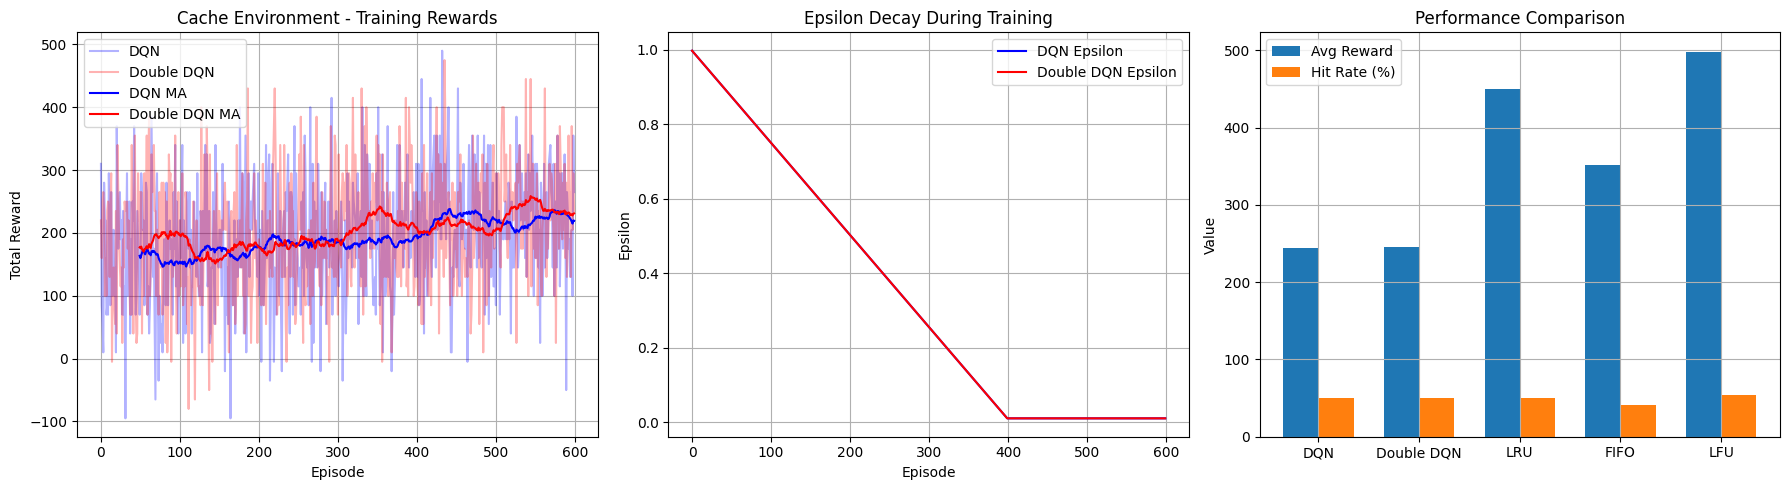

In [16]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, OrderedDict
import matplotlib.pyplot as plt


class CacheEnv(gym.Env):
    def __init__(self, cache_size=8, memory_size=64, sequence_length=100):
        super(CacheEnv, self).__init__()
        self.cache_size = cache_size
        self.memory_size = memory_size
        self.sequence_length = sequence_length
        self.cache = OrderedDict()
        self.access_sequence = []
        self.current_step = 0
        self.action_space = spaces.Discrete(cache_size)
        self.observation_space = spaces.Box(low=-1, high=memory_size, shape=(cache_size + 4,), dtype=np.float32)
        self.hits = 0
        self.misses = 0
        self.total_accesses = 0

    def _generate_access_pattern(self, pattern_type='mixed'):
        if pattern_type == 'sequential':
            return [i % self.memory_size for i in range(self.sequence_length)]
        elif pattern_type == 'loop':
            loop_size = min(10, self.memory_size)
            return [i % loop_size for i in range(self.sequence_length)]
        elif pattern_type == 'random':
            return [random.randint(0, self.memory_size - 1) for _ in range(self.sequence_length)]
        else:
            seq = []
            hot_set = list(range(6))
            warm_set = list(range(6, 12))
            cold_set = list(range(12, self.memory_size))
            for _ in range(self.sequence_length):
                r = random.random()
                if r < 0.6:
                    seq.append(random.choice(hot_set))
                elif r < 0.85:
                    seq.append(random.choice(warm_set))
                else:
                    seq.append(random.choice(cold_set))
            return seq

    def _get_state(self):
        cache_contents = list(self.cache.keys()) if self.cache else []
        cache_contents += [-1] * (self.cache_size - len(cache_contents))
        next_addr = self.access_sequence[self.current_step] if self.current_step < len(self.access_sequence) else -1
        future_addrs = []
        for i in range(1, min(4, len(self.access_sequence) - self.current_step)):
            future_addrs.append(self.access_sequence[self.current_step + i])
        while len(future_addrs) < 3:
            future_addrs.append(-1)
        state = cache_contents + [next_addr] + future_addrs
        return np.array(state, dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        pattern = options.get('pattern', 'mixed') if options else 'mixed'
        self.access_sequence = self._generate_access_pattern(pattern)
        self.cache = OrderedDict()
        self.current_step = 0
        self.hits = 0
        self.misses = 0
        self.total_accesses = 0
        return self._get_state(), {}

    def step(self, action):
        if self.current_step >= len(self.access_sequence):
            return self._get_state(), 0, True, False, {}
        addr = self.access_sequence[self.current_step]
        reward = 0
        if addr in self.cache:
            self.hits += 1
            reward = 10
            self.cache.move_to_end(addr)
        else:
            self.misses += 1
            reward = -5
            if len(self.cache) >= self.cache_size:
                cache_list = list(self.cache.keys())
                if action < len(cache_list):
                    evict_addr = cache_list[action]
                    del self.cache[evict_addr]
                else:
                    self.cache.popitem(last=False)
            self.cache[addr] = 1
        self.total_accesses += 1
        self.current_step += 1
        done = self.current_step >= len(self.access_sequence)
        return self._get_state(), reward, done, False, {}

    def render(self):
        hit_rate = self.hits / max(1, self.total_accesses) * 100
        print(f"Step: {self.current_step}/{len(self.access_sequence)}")
        print(f"Cache: {list(self.cache.keys())}")
        print(f"Hits: {self.hits}, Misses: {self.misses}, Hit Rate: {hit_rate:.2f}%")


class LRUPolicy:
    def __init__(self, cache_size):
        self.cache = OrderedDict()
        self.cache_size = cache_size

    def access(self, addr):
        if addr in self.cache:
            self.cache.move_to_end(addr)
            return True
        else:
            if len(self.cache) >= self.cache_size:
                self.cache.popitem(last=False)
            self.cache[addr] = 1
            return False

    def reset(self):
        self.cache = OrderedDict()


class FIFOPolicy:
    def __init__(self, cache_size):
        self.cache = OrderedDict()
        self.cache_size = cache_size

    def access(self, addr):
        if addr in self.cache:
            return True
        else:
            if len(self.cache) >= self.cache_size:
                self.cache.popitem(last=False)
            self.cache[addr] = 1
            return False

    def reset(self):
        self.cache = OrderedDict()


class LFUPolicy:
    def __init__(self, cache_size):
        self.cache = {}
        self.freq = {}
        self.cache_size = cache_size

    def access(self, addr):
        if addr in self.cache:
            self.freq[addr] += 1
            return True
        else:
            if len(self.cache) >= self.cache_size:
                min_freq_addr = min(self.freq, key=self.freq.get)
                del self.cache[min_freq_addr]
                del self.freq[min_freq_addr]
            self.cache[addr] = 1
            self.freq[addr] = 1
            return False

    def reset(self):
        self.cache = {}
        self.freq = {}


class DQNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate=0.001, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay_steps=50000,
                 replay_memory_size=50000, batch_size=64, target_update_freq=500):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_steps = epsilon_decay_steps
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.q_network = DQNetwork(state_dim, action_dim).to(self.device)
        self.target_network = DQNetwork(state_dim, action_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.replay_memory = ReplayMemory(replay_memory_size)
        self.steps = 0

    def select_action(self, state, evaluation=False):
        if evaluation or random.random() > self.epsilon:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.q_network(state_tensor)
                return q_values.argmax().item()
        else:
            return random.randrange(self.action_dim)

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_memory.push(state, action, reward, next_state, done)

    def update_epsilon(self):
        self.steps += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                       max(0, (self.epsilon_decay_steps - self.steps) / self.epsilon_decay_steps)

    def optimize_model(self):
        if len(self.replay_memory) < self.batch_size:
            return None
        transitions = self.replay_memory.sample(self.batch_size)
        batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)
        batch_state = torch.FloatTensor(np.array(batch_state)).to(self.device)
        batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(self.device)
        batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(self.device)
        batch_next_state = torch.FloatTensor(np.array(batch_next_state)).to(self.device)
        batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(self.device)
        current_q_values = self.q_network(batch_state).gather(1, batch_action)
        with torch.no_grad():
            max_next_q_values = self.target_network(batch_next_state).max(1)[0].unsqueeze(1)
            target_q_values = batch_reward + (1 - batch_done) * self.gamma * max_next_q_values
        loss = nn.MSELoss()(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def save(self, filepath):
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'steps': self.steps,
            'epsilon': self.epsilon
        }, filepath)

    def load(self, filepath):
        checkpoint = torch.load(filepath)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.steps = checkpoint['steps']
        self.epsilon = checkpoint['epsilon']


class DoubleDQNAgent(DQNAgent):
    def optimize_model(self):
        if len(self.replay_memory) < self.batch_size:
            return None
        transitions = self.replay_memory.sample(self.batch_size)
        batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)
        batch_state = torch.FloatTensor(np.array(batch_state)).to(self.device)
        batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(self.device)
        batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(self.device)
        batch_next_state = torch.FloatTensor(np.array(batch_next_state)).to(self.device)
        batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(self.device)
        current_q_values = self.q_network(batch_state).gather(1, batch_action)
        with torch.no_grad():
            next_actions = self.q_network(batch_next_state).argmax(1).unsqueeze(1)
            next_q_values = self.target_network(batch_next_state).gather(1, next_actions)
            target_q_values = batch_reward + (1 - batch_done) * self.gamma * next_q_values
        loss = nn.MSELoss()(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()


def train_agent(env, agent, num_episodes=500, max_steps=200):
    episode_rewards = []
    epsilon_history = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        for step in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            agent.store_transition(state, action, reward, next_state, done)
            agent.optimize_model()
            agent.update_epsilon()
            if agent.steps % agent.target_update_freq == 0:
                agent.update_target_network()
            state = next_state
            episode_reward += reward
            if done or truncated:
                break
        episode_rewards.append(episode_reward)
        epsilon_history.append(agent.epsilon)
        if (episode + 1) % 100 == 0:
            mean_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode + 1}/{num_episodes}, Mean Reward: {mean_reward:.2f}, Epsilon: {agent.epsilon:.3f}")
    return episode_rewards, epsilon_history


def evaluate_agent(env, agent, num_episodes=10):
    eval_rewards = []
    hit_rates = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        step_count = 0
        while not done and step_count < 200:
            action = agent.select_action(state, evaluation=True)
            next_state, reward, done, truncated, _ = env.step(action)
            episode_reward += reward
            state = next_state
            step_count += 1
            if truncated:
                break
        hit_rate = env.hits / max(1, env.total_accesses) * 100
        eval_rewards.append(episode_reward)
        hit_rates.append(hit_rate)
    return eval_rewards, hit_rates


def evaluate_baseline(env, policy, num_episodes=10):
    rewards = []
    hit_rates = []
    for episode in range(num_episodes):
        policy.reset()
        env.reset()
        total_reward = 0
        hits = 0
        total = 0
        for addr in env.access_sequence:
            is_hit = policy.access(addr)
            if is_hit:
                hits += 1
                total_reward += 10
            else:
                total_reward -= 1
            total += 1
        hit_rate = hits / max(1, total) * 100
        rewards.append(total_reward)
        hit_rates.append(hit_rate)
    return rewards, hit_rates


def train_cache_comparison(num_episodes=600):
    env = CacheEnv(cache_size=8, memory_size=64, sequence_length=100)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    print("Training Cache with DQN")
    dqn_agent = DQNAgent(state_dim, action_dim, learning_rate=0.001, gamma=0.95,
                         epsilon_start=1.0, epsilon_end=0.01, epsilon_decay_steps=40000,
                         replay_memory_size=30000, batch_size=64, target_update_freq=300)
    dqn_rewards, dqn_epsilon = train_agent(env, dqn_agent, num_episodes, max_steps=100)
    dqn_agent.save('cache_dqn.pth')
    dqn_eval, dqn_hits = evaluate_agent(env, dqn_agent, num_episodes=10)
    print("\n\nTraining Cache with Double DQN")
    ddqn_agent = DoubleDQNAgent(state_dim, action_dim, learning_rate=0.001, gamma=0.95,
                                epsilon_start=1.0, epsilon_end=0.01, epsilon_decay_steps=40000,
                                replay_memory_size=30000, batch_size=64, target_update_freq=300)
    ddqn_rewards, ddqn_epsilon = train_agent(env, ddqn_agent, num_episodes, max_steps=100)
    ddqn_agent.save('cache_ddqn.pth')
    ddqn_eval, ddqn_hits = evaluate_agent(env, ddqn_agent, num_episodes=10)
    print("\n\nEvaluating Baselines")
    lru_policy = LRUPolicy(cache_size=8)
    lru_eval, lru_hits = evaluate_baseline(env, lru_policy, num_episodes=10)
    fifo_policy = FIFOPolicy(cache_size=8)
    fifo_eval, fifo_hits = evaluate_baseline(env, fifo_policy, num_episodes=10)
    lfu_policy = LFUPolicy(cache_size=8)
    lfu_eval, lfu_hits = evaluate_baseline(env, lfu_policy, num_episodes=10)
    print(f"\nDQN Hit Rate: {np.mean(dqn_hits):.2f}%")
    print(f"Double DQN Hit Rate: {np.mean(ddqn_hits):.2f}%")
    print(f"LRU Hit Rate: {np.mean(lru_hits):.2f}%")
    print(f"FIFO Hit Rate: {np.mean(fifo_hits):.2f}%")
    print(f"LFU Hit Rate: {np.mean(lfu_hits):.2f}%")
    return (dqn_rewards, dqn_epsilon, dqn_eval, dqn_hits,
            ddqn_rewards, ddqn_epsilon, ddqn_eval, ddqn_hits,
            lru_eval, lru_hits, fifo_eval, fifo_hits, lfu_eval, lfu_hits)


def plot_cache_comparison(dqn_rewards, ddqn_rewards, dqn_epsilon, ddqn_epsilon,
                          dqn_eval, ddqn_eval, lru_eval, fifo_eval, lfu_eval,
                          dqn_hits, ddqn_hits, lru_hits, fifo_hits, lfu_hits):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(dqn_rewards, alpha=0.3, label='DQN', color='blue')
    axes[0].plot(ddqn_rewards, alpha=0.3, label='Double DQN', color='red')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Total Reward')
    axes[0].set_title('Cache Environment - Training Rewards')
    axes[0].grid(True)

    window = 50
    if window > 0:
        dqn_ma = np.convolve(dqn_rewards, np.ones(window) / window, mode='valid')
        ddqn_ma = np.convolve(ddqn_rewards, np.ones(window) / window, mode='valid')
        axes[0].plot(np.arange(len(dqn_ma)) + window - 1, dqn_ma, label='DQN MA', color='blue')
        axes[0].plot(np.arange(len(ddqn_ma)) + window - 1, ddqn_ma, label='Double DQN MA', color='red')

    axes[0].legend()

    axes[1].plot(dqn_epsilon, label='DQN Epsilon', color='blue')
    axes[1].plot(ddqn_epsilon, label='Double DQN Epsilon', color='red')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Epsilon')
    axes[1].set_title('Epsilon Decay During Training')
    axes[1].grid(True)
    axes[1].legend()

    bars = ['DQN', 'Double DQN', 'LRU', 'FIFO', 'LFU']
    avg_rewards = [
        np.mean(dqn_eval),
        np.mean(ddqn_eval),
        np.mean(lru_eval),
        np.mean(fifo_eval),
        np.mean(lfu_eval)
    ]
    hit_rates = [
        np.mean(dqn_hits),
        np.mean(ddqn_hits),
        np.mean(lru_hits),
        np.mean(fifo_hits),
        np.mean(lfu_hits)
    ]
    x = np.arange(len(bars))
    width = 0.35
    axes[2].bar(x - width / 2, avg_rewards, width, label='Avg Reward')
    axes[2].bar(x + width / 2, hit_rates, width, label='Hit Rate (%)')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(bars)
    axes[2].set_ylabel('Value')
    axes[2].set_title('Performance Comparison')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    (dqn_rewards, dqn_epsilon, dqn_eval, dqn_hits,
     ddqn_rewards, ddqn_epsilon, ddqn_eval, ddqn_hits,
     lru_eval, lru_hits, fifo_eval, fifo_hits, lfu_eval, lfu_hits) = train_cache_comparison(num_episodes=600)

    plot_cache_comparison(dqn_rewards, ddqn_rewards, dqn_epsilon, ddqn_epsilon,
                          dqn_eval, ddqn_eval, lru_eval, fifo_eval, lfu_eval,
                          dqn_hits, ddqn_hits, lru_hits, fifo_hits, lfu_hits)
